In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [16]:
words = open('names.txt', 'r').read().splitlines()
print("max word length:", max(len(w) for w in words))
print(words[:8])

# inverted index
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(f'vocab_size: {vocab_size}')

max word length: 15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size: 27


In [17]:
# Build dataset 

block_size = 8 # context length: number of previous characters to consider for predicting next one

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            i = stoi[c]
            X.append(context)
            Y.append(i)
            # print(''.join(itos[i] for i in context), '--->', itos[i])
            context = context[1:] + [i]
    return torch.tensor(X), torch.tensor(Y)


import random
random.seed(42)
random.shuffle(words)

n1, n2 = int(0.8 * len(words)), int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])            # 80% of the data
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

print("total dataset size:", len(words))
print(f"data split training {len(Xtr)} dev {len(Xdev)} test {len(Xte)}")    


total dataset size: 32033
data split training 182625 dev 22655 test 22866


In [18]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[i.item()] for i in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [19]:
# Neural Network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        # print(f"Linear {x.shape} {self.weight.shape}")
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight, self.bias] if self.bias is not None else [self.weight]
# ----------------------------------------------------------------------------
   
class BatchNorm1d:
    def __init__(self, dim, eps=1e-05, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim) # gain
        self.beta = torch.zeros(dim) # bias
        # running mean and variance
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass 
        if self.training:
            if x.ndim == 2:
                xmean = x.mean(dim=0, keepdim=True)
                xvar = x.var(dim=0, keepdim=True)
            elif x.ndim == 3:
                xmean = x.mean(dim=(0,1), keepdim=True)
                xvar = x.var(dim=(0,1), keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize and scale
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = xmean * self.momentum + self.running_mean * (1 - self.momentum)
                self.running_var = xvar * self.momentum + self.running_var * (1 - self.momentum)
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
# -----------------------------------------------------------------------------
        
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
# ----------------------------------------------------------------------------

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]
# ----------------------------------------------------------------------------
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            self.out = x.squeeze(1)
        else:
            self.out = x
        return self.out
    
    def parameters(self):
        return []
# ----------------------------------------------------------------------------
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
# ----------------------------------------------------------------------------

In [20]:
torch.manual_seed(42);

In [21]:
n_embed = 24 # dimensionality of character embedding
n_hidden = 128 # no of neurons in the hidden layer

model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])
# parameters init
with torch.no_grad():
    model.layers[-1].weight * 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [22]:
ix = torch.randint(low=0, high=Xtr.shape[0], size=(4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(logits.shape)

torch.Size([4, 8])
torch.Size([4, 27])


In [23]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [24]:
e = torch.randint(0, 10, (2, 3, 4))
print(e)
m = e.sum(dim=0, keepdim=True)
print(m)
e.sum(dim=(0,1), keepdim=True)

tensor([[[6, 6, 3, 9],
         [3, 1, 9, 8],
         [1, 0, 9, 2]],

        [[2, 3, 4, 2],
         [3, 6, 8, 0],
         [7, 7, 4, 4]]])
tensor([[[ 8,  9,  7, 11],
         [ 6,  7, 17,  8],
         [ 8,  7, 13,  6]]])


tensor([[[22, 23, 37, 25]]])

In [25]:
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update ratio

# forward pass
for i in range(max_steps):
    # mini batch
    ix = torch.randint(0, len(Xtr), (batch_size,))
    Yb, Xb = Ytr[ix], Xtr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    # for layer in layers: layer.out.retain_grad() # DEBUG: Only for debugging
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track stats
    if i % 1000 == 0:
        print(f'{i:05d}/{max_steps:05d} loss: {loss.item():.4f}')
    lossi.append(loss.log10().item())  
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    #if len(lossi) == 10000: break



00000/200000 loss: 3.6270
01000/200000 loss: 2.1790
02000/200000 loss: 2.3080
03000/200000 loss: 2.1322
04000/200000 loss: 2.2811
05000/200000 loss: 2.0046
06000/200000 loss: 2.0935
07000/200000 loss: 2.2270
08000/200000 loss: 1.9467
09000/200000 loss: 2.2799


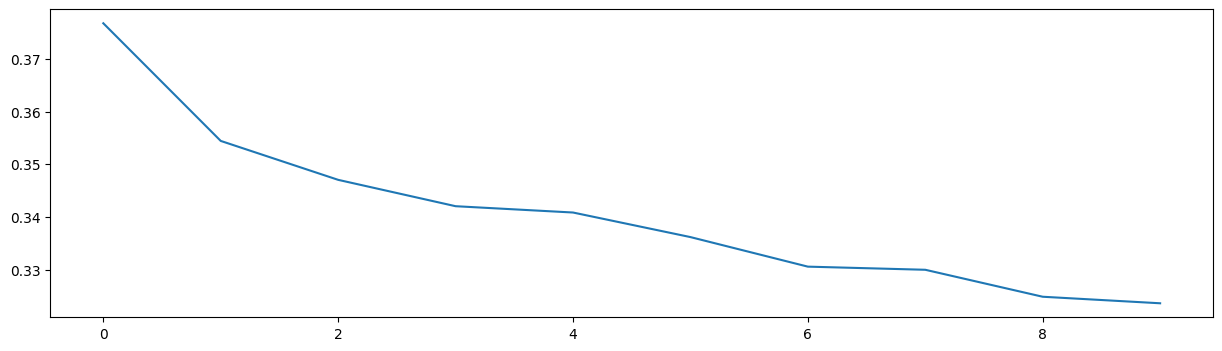

In [26]:
plt.figure(figsize=(15, 4)) # width and height of the plot
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [27]:
# put layers in eval mode (for batchnorm)
for layer in model.layers:
    layer.training = False

#calculate loss
@torch.no_grad() 
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(f"{split:10} loss: ", loss.item())

for layer in model.layers:
  layer.training = False

split_loss('train')
split_loss('val')
    

train      loss:  2.1239397525787354
val        loss:  2.1542117595672607


In [28]:

def sample():
    out = []
    context = [0] * block_size
    name = ''
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    return ''.join(itos[i] for i in out)

for _ in range(10):
    print(sample())


edente
erlah
denalion
lezson
leuss
ibi
mostince
hezaeph
maden
izia
